In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [2]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.1" 2021-10-19; OpenJDK Runtime Environment Temurin-17.0.1+12 (build 17.0.1+12); OpenJDK 64-Bit Server VM Temurin-17.0.1+12 (build 17.0.1+12, mixed mode)
  Starting server from /Users/per-christian/opt/anaconda3/envs/tdt4173/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/2p/72g9pz790kb771nk16cvz7dr0000gn/T/tmpxlmb6wdf
  JVM stdout: /var/folders/2p/72g9pz790kb771nk16cvz7dr0000gn/T/tmpxlmb6wdf/h2o_per_christian_started_from_python.out
  JVM stderr: /var/folders/2p/72g9pz790kb771nk16cvz7dr0000gn/T/tmpxlmb6wdf/h2o_per_christian_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.4
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_per_christian_lw4obv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [3]:
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

In [4]:
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')


In [5]:
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')



In [6]:
X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')


# Todo list

1. Decide if creating three seperate models, or incorporating location as feature

# Data Preprocessing

**1. Merge observed and estimated training data**

**2. Handle NaN values**
- Look through all features and handle seperately, according to nature of the feature

**3.  Aggregate weather data from every 15 minute to hourly.**
- Average, sum, max/min, first/last etc. depending on the nature of the metric.
- Ensure the timestamps between weather data and power production align.

**4. Handle missing solar power measurements from 2022-10-21 01:00 - 2022-10-28 21:00**

### 1. Merge observed and estimated training data**

In [7]:
def merge_training_data(location):
    if location.lower() == 'a':
        X_train = pd.concat([X_train_observed_a,X_train_estimated_a])
    elif location.lower() == 'b':
        X_train = pd.concat([X_train_observed_b,X_train_estimated_b])
    elif location.lower() == 'c':
        X_train = pd.concat([X_train_observed_c,X_train_estimated_c])
    else:
        raise ValueError(f"Invalid location: {location}")
    return X_train

In [8]:
X_train_a = merge_training_data('a')
X_train_b = merge_training_data('b')
X_train_c = merge_training_data('c')

### 2. Handle NaN values

In [9]:
##

### 3. Aggregate weather data from every 15 minute to hourly averages

In [10]:
highly_relevant = [
    'clear_sky_rad:W', 
    'direct_rad:W', 
    'direct_rad_1h:J', 
    'diffuse_rad:W', 
    'diffuse_rad_1h:J',
    'effective_cloud_cover:p', 
    'is_day:idx', 
    'is_in_shadow:idx', 
    'sun_elevation:d', 
    'sun_azimuth:d',
    'total_cloud_cover:p',
    'clear_sky_energy_1h:J'
]

moderately_relevant = [
    'fresh_snow_6h:cm'
    'fresh_snow_12h:cm',
    'fresh_snow_24h:cm',
    'ceiling_height_agl:m', 
    'cloud_base_agl:m', 
    'snow_depth:cm', 
    'fresh_snow_1h:cm', 
    'fresh_snow_3h:cm',
    'wind_speed_10m:ms', 
    'wind_speed_u_10m:ms', 
    'wind_speed_v_10m:ms', 
    'visibility:m'
]

less_relevant = [
    'absolute_humidity_2m:gm3', 
    'dew_point_2m:K', 
    'msl_pressure:hPa', 
    'precip_5min:mm', 
    'rain_water:kgm2',
    'sfc_pressure:hPa', 
    'snow_density:kgm3', 
    'snow_melt_10min:mm',
    'air_density_2m:kgm3'
]

not_included = ['elevation:m',
 'pressure_50m:hPa',
 'super_cooled_liquid_water:kgm2',
 'precip_type_5min:idx',
 'dew_or_rime:idx',
 'snow_water:kgm2',
 'prob_rime:p',
 'snow_drift:idx',
 't_1000hPa:K',
 'wind_speed_w_1000hPa:ms',
 'relative_humidity_1000hPa:p',
 'date_calc',
 'pressure_100m:hPa']


#not_included = list(set(X_train_b.columns)-set(highly_relevant) - set(moderately_relevant)-set(less_relevant))


#len(highly_relevant)+len(moderately_relevant)+len(less_relevant) + len(not_included)

In [11]:
agg_dict1 = {'clear_sky_energy_1h:J': 'sum',
 'diffuse_rad_1h:J': 'sum',
 'direct_rad_1h:J': 'sum',
 'precip_5min:mm': 'sum',
 'fresh_snow_1h:cm': 'sum',
 'fresh_snow_3h:cm': 'sum',
 'snow_melt_10min:mm': 'sum',
 'rain_water:kgm2': 'sum',
 'super_cooled_liquid_water:kgm2': 'sum',
 'wind_speed_10m:ms': 'max',
 'dew_or_rime:idx': 'sum',
 'is_day:idx': 'sum',
 'is_in_shadow:idx': 'sum',
 'snow_drift:idx': 'sum',
 'precip_type_5min:idx': 'sum',
 'absolute_humidity_2m:gm3': 'mean',
 'air_density_2m:kgm3': 'mean',
 'ceiling_height_agl:m': 'mean',
 'clear_sky_rad:W': 'mean',
 'cloud_base_agl:m': 'mean',
 'dew_point_2m:K': 'mean',
 'diffuse_rad:W': 'mean',
 'direct_rad:W': 'mean',
 'effective_cloud_cover:p': 'mean',
 'elevation:m': 'mean',
 'msl_pressure:hPa': 'mean',
 'pressure_100m:hPa': 'mean',
 'pressure_50m:hPa': 'mean',
 'prob_rime:p': 'mean',
 'relative_humidity_1000hPa:p': 'mean',
 'sfc_pressure:hPa': 'mean',
 'snow_density:kgm3': 'mean',
 'snow_depth:cm': 'mean',
 'sun_azimuth:d': 'mean',
 'sun_elevation:d': 'mean',
 't_1000hPa:K': 'mean',
 'total_cloud_cover:p': 'mean',
 'visibility:m': 'mean',
 'wind_speed_u_10m:ms': 'mean',
 'wind_speed_v_10m:ms': 'mean',
 'wind_speed_w_1000hPa:ms': 'mean',
 'fresh_snow_12h:cm': 'last',
 'snow_water:kgm2': 'mean',
 'fresh_snow_24h:cm':'last',
 'fresh_snow_6h:cm':'last'}

agg_dict2 = {
 'absolute_humidity_2m:gm3': 'mean',
 'air_density_2m:kgm3': 'mean',
 'ceiling_height_agl:m': 'mean',
 'clear_sky_energy_1h:J': 'sum',
 'clear_sky_rad:W': 'mean',
 'cloud_base_agl:m': 'mean',
 'dew_or_rime:idx': 'mode',
 'dew_point_2m:K': 'mean',
 'diffuse_rad:W': 'mean',
 'diffuse_rad_1h:J': 'sum',
 'direct_rad:W': 'mean',
 'direct_rad_1h:J': 'sum',
 'effective_cloud_cover:p': 'mean',
 'elevation:m': 'mean',
 'fresh_snow_12h:cm': 'sum',
 'fresh_snow_1h:cm': 'sum',
 'fresh_snow_24h:cm': 'sum',
 'fresh_snow_3h:cm': 'sum',
 'fresh_snow_6h:cm': 'sum',
 'is_day:idx': 'max',
 'is_in_shadow:idx': 'max',
 'msl_pressure:hPa': 'mean',
 'precip_5min:mm': 'sum',
 'precip_type_5min:idx': 'mode',
 'pressure_100m:hPa': 'mean',
 'pressure_50m:hPa': 'mean',
 'prob_rime:p': 'mean',
 'rain_water:kgm2': 'sum',
 'relative_humidity_1000hPa:p': 'mean',
 'sfc_pressure:hPa': 'mean',
 'snow_density:kgm3': 'mean',
 'snow_depth:cm': 'mean',
 'snow_drift:idx': 'mode',
 'snow_melt_10min:mm': 'sum',
 'snow_water:kgm2': 'sum',
 'sun_azimuth:d': 'mean',
 'sun_elevation:d': 'mean',
 'super_cooled_liquid_water:kgm2': 'max',
 't_1000hPa:K': 'mean',
 'total_cloud_cover:p': 'mean',
 'visibility:m': 'mean',
 'wind_speed_10m:ms': 'mean',
 'wind_speed_u_10m:ms': 'mean',
 'wind_speed_v_10m:ms': 'mean',
 'wind_speed_w_1000hPa:ms': 'mean'
}


remaining = list(set(X_train_b.columns) - set(agg_dict2.keys()))


In [12]:
def transform_to_hourly(X,agg_dict, mean = False):
    if mean:
        return X.resample('H', on = 'date_forecast').mean()
    return X.resample('H', on = 'date_forecast').agg(agg_dict)

X_train_hourly_b = transform_to_hourly(X_train_b,agg_dict1)
X_test_hourly_b = transform_to_hourly(X_test_estimated_b, agg_dict1)


### 4. Handle missing solar power measurements from 2022-10-21 01:00 - 2022-10-28 21:00

In [30]:
#Remove data in X_train_hourly that has timestamp that does not exist in train_a/b/c
X_train_b = X_train_hourly_b.copy()[X_train_hourly_b.index.isin(train_b['time'])]

#Remove first row of train_b as this does not exist in X_train_b
y_train_b = train_b.iloc[1:,:]

# Exploratory Data Analysis

**1. Plot individual features over time**\
**2. Time series plots of features vs solar power production -> identify correlations**\
**3. Correlation Matrix**

### 1. Plot individual features 

In [32]:
#Currently plotting on non-aggregated dataset. Should we consider changing to the modified dataframe?
def plot_feature(feature_name,seaborn_style = True):
    if seaborn_style:
        sns.set_style("whitegrid")
    else:
        seaborn.reset_defaults()
    fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
    X_train_observed_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='red')
    X_train_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='blue')
    X_test_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test  A', color='green')

    X_train_observed_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='red')
    X_train_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='blue')
    X_test_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='green')

    X_train_observed_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='red')
    X_train_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='blue')
    X_test_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='green')

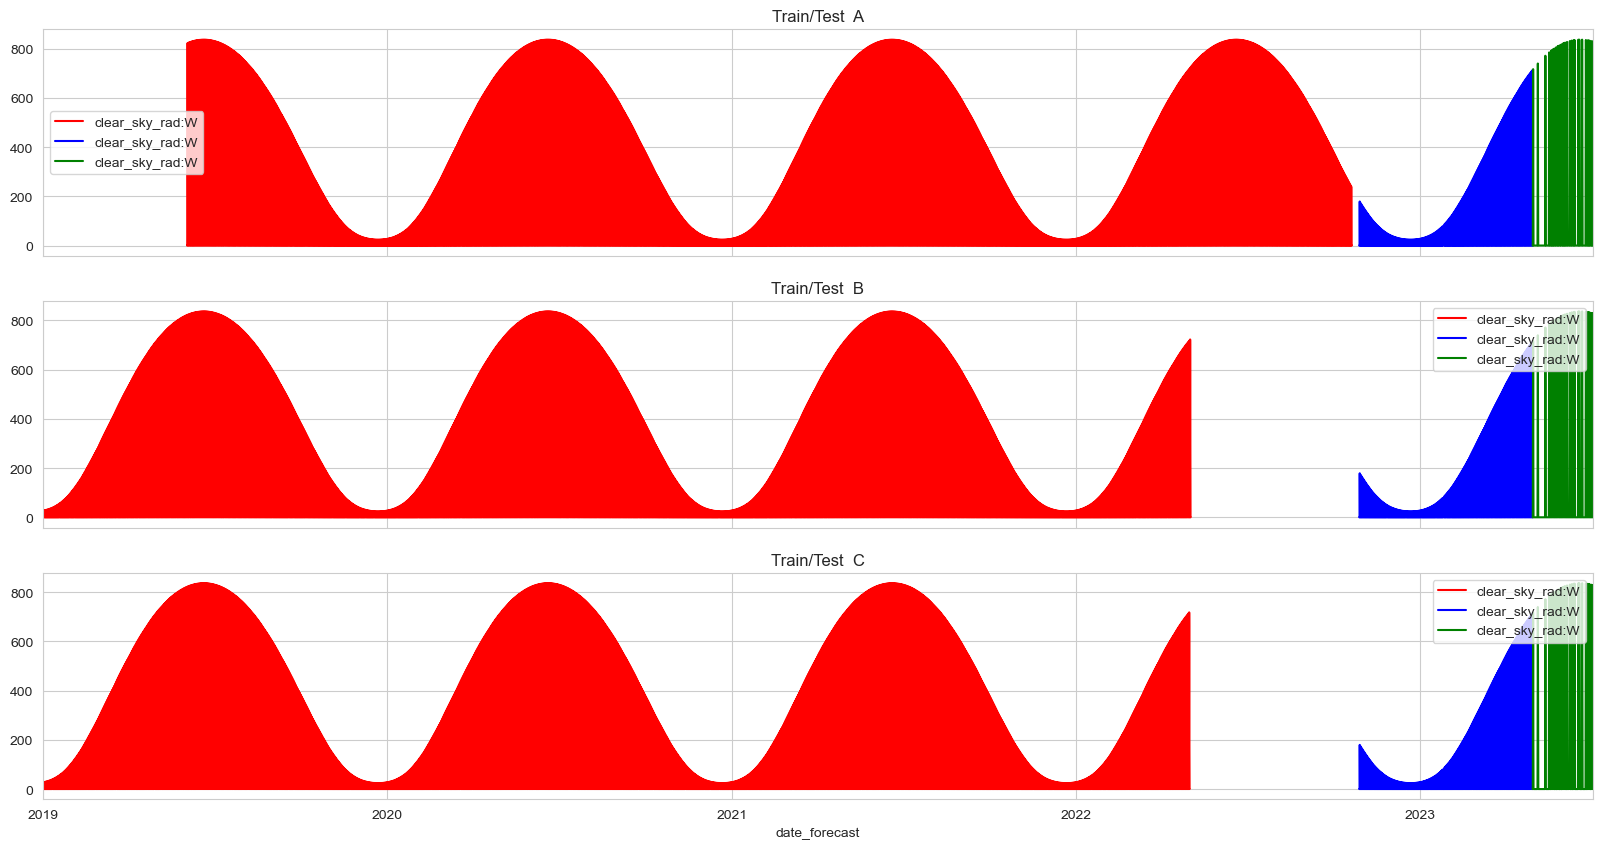

In [33]:
feats = list(X_train_observed_a.columns)
plot_feature(feats[5])

### 2. Time series plots of features vs solar power production 

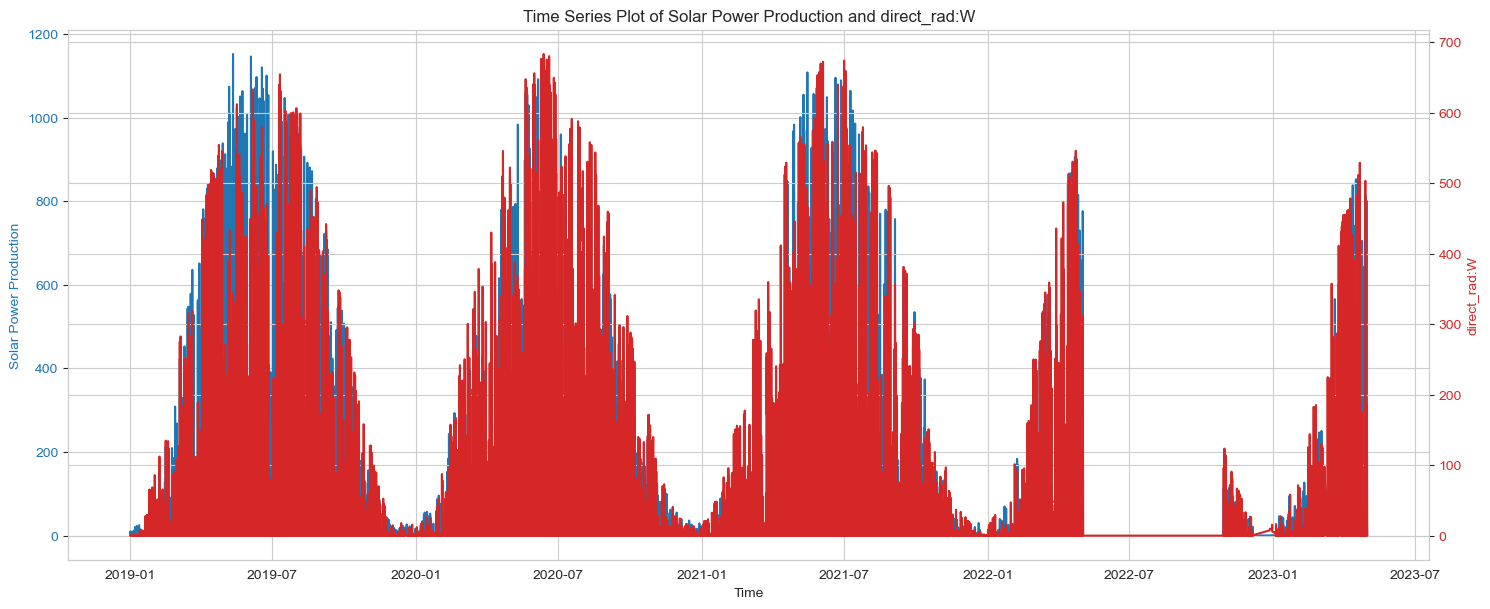

In [34]:
#Time series plot of feature vs production
#Here we are plotting on the modified dataset
def time_series_plot(feature):
    fig, ax1 = plt.subplots(figsize=(15, 6))
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Solar Power Production', color='tab:blue')
    ax1.plot(y_train_b['time'], y_train_b['pv_measurement'], color='tab:blue', label='Solar Power Production')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()  
    ax2.set_ylabel(feature, color='tab:red')  
    ax2.plot(X_train_b.index, X_train_b[feature], color='tab:red', label=feature)
    ax2.tick_params(axis='y', labelcolor='tab:red')

    fig.tight_layout()
    plt.title(f'Time Series Plot of Solar Power Production and {feature}')
    plt.show()

time_series_plot('direct_rad:W')

### 3. Correlation Heatmap 


In [18]:
##

# Feature Engineering

In [36]:
#Create time-based features for hour,day, month
def add_time_feat(X):
    X_frame = X.copy()
    X_frame['year'] = X_frame.index.year
    X_frame['month'] = X_frame.index.month
    X_frame['day'] = X_frame.index.day
    X_frame['weekday'] = X_frame.index.weekday
    X_frame['hour'] = X_frame.index.hour
    return X_frame

In [39]:
X_train_b = add_time_feat(X_train_b)
X_test_b = add_time_feat(X_test_hourly_b)

# Build H2O Model 

In [41]:
merged_data = X_train_b.copy()
merged_data['pv_measurement'] = y_train_b['pv_measurement'].values

y = 'pv_measurement'
x = list(X_train_b.columns)
b_train = h2o.H2OFrame(merged_data)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [43]:
from h2o.automl import H2OAutoML
aml = H2OAutoML(
    max_models = 10,
    max_runtime_secs = 120,
    #exclude_algos =['DeepLearning'],
    seed = 1,
    # stopping_metric ='logloss',
    sort_metric ='mae',
    balance_classes = False,
    project_name ='Project1'
)

aml.train(x=x, y=y, training_frame=b_train)

AutoML progress: |
11:33:25.240: AutoML: XGBoost is not available; skipping it.
11:33:25.258: _train param, Dropping bad and constant columns: [elevation:m]

████████████████████████████████████████████████████████
11:35:13.286: XRT_1_AutoML_1_20231015_113325 [DRF XRT (Extremely Randomized Trees)] failed: java.lang.AssertionError

███████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_4_AutoML_1_20231015_113325


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    210                210                         476018                 10           10           10            27            531           175.638

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 261.5708126493591
RMSE: 16.173150980849684
MAE: 8.991734899349971
RMSLE: NaN
Mean Residual Deviance: 261.5708126493591

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 3146.0076426854
RMSE: 56.08928277920302
MAE: 25.559171913390237
RMSLE: NaN
Mean Residual Deviance: 3146.0076426854

Cross-Validation Metrics Summary: 
                        mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     25.5592   0.842898    25.2622       26.9869       24.8335       25.1255       25.5877
mean_residual_deviance  3146.01   205.517     3156.27       3473.25       2921.96       3038.66       3139.89
mse                     3146.01   205.517     3156.27       3473.25       2921.96       3038.66       3139.89
r2                      0.916294  0.00659033  0.916296      0.905151      0.921875      0.920289      0.917858
residual_deviance       3146.01   205.517     3156.27       3473.25       2921.96       3038.66       3139.89
rmse                    56.0658   1.81465     56.1807       58.9343       54.0552       55.1241       56.0347
rmsle                   nan       0           nan           nan           nan           nan           nan

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------
     2023-10-15 11:35:10  13.604 sec  0.0                193.94575122075062  129.80636860187204  37614.95441658129
     2023-10-15 11:35:10  13.729 sec  5.0                125.52788459733614  82.16852128981695   15757.249811482141
     2023-10-15 11:35:10  13.843 sec  10.0               86.7397170434882    55.5276226604659    7523.778512784396
     2023-10-15 11:35:10  13.954 sec  15.0               65.60826383343006   40.55319145385596   4304.444283236967
     2023-10-15 11:35:10  14.062 sec  20.0               53.017295882738715  31.13938490569221   2810.8336627178633
     2023-10-15 11:35:10  14.169 sec  25.0               46.033514053922325  25.638785719965473  2119.0844161526643
     2023-10-15 11:35:10  14.260 sec  30.0               41.67337803838848   22.104998149486626  1736.6704371304388
     2023-10-15 11:35:10  14.345 sec  35.0               38.44708256933257   19.785130191615835  1478.1781580930767
     2023-10-15 11:35:10  14.427 sec  40.0               35.867212979826064  18.170797028502317  1286.456966940203
     2023-10-15 11:35:10  14.504 sec  45.0               34.12931279430712   17.149197342671048  1164.8099918116557
---  ---                  ---         ---                ---                 ---                 ---
     2023-10-15 11:35:12  16.166 sec  165.0              19.316870543388475  10.537701368241414  373.1414875900293
     2023-10-15 11:35:12  16.237 sec  170.0              18.864630405609592  10.301098892829057  355.87428034025
     2023-10-15 11:35:12  16.307 sec  175.0              18.505709346454967  10.129621001329433  342.46127841547076
     2023-10-15 11:35:12  16.376 sec  180.0              18.161670472619676  9.95851420601368    329.8462743560254
     2023-10-15 11:35:

In [45]:
lb = aml.leaderboard
leader = aml.leader
leader

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_4_AutoML_1_20231015_113325


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    210                210                         476018                 10           10           10            27            531           175.638

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 261.5708126493591
RMSE: 16.173150980849684
MAE: 8.991734899349971
RMSLE: NaN
Mean Residual Deviance: 261.5708126493591

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 3146.0076426854
RMSE: 56.08928277920302
MAE: 25.559171913390237
RMSLE: NaN
Mean Residual Deviance: 3146.0076426854

Cross-Validation Metrics Summary: 
                        mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     25.5592   0.842898    25.2622       26.9869       24.8335       25.1255       25.5877
mean_residual_deviance  3146.01   205.517     3156.27       3473.25       2921.96       3038.66       3139.89
mse                     3146.01   205.517     3156.27       3473.25       2921.96       3038.66       3139.89
r2                      0.916294  0.00659033  0.916296      0.905151      0.921875      0.920289      0.917858
residual_deviance       3146.01   205.517     3156.27       3473.25       2921.96       3038.66       3139.89
rmse                    56.0658   1.81465     56.1807       58.9343       54.0552       55.1241       56.0347
rmsle                   nan       0           nan           nan           nan           nan           nan

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------
     2023-10-15 11:35:10  13.604 sec  0.0                193.94575122075062  129.80636860187204  37614.95441658129
     2023-10-15 11:35:10  13.729 sec  5.0                125.52788459733614  82.16852128981695   15757.249811482141
     2023-10-15 11:35:10  13.843 sec  10.0               86.7397170434882    55.5276226604659    7523.778512784396
     2023-10-15 11:35:10  13.954 sec  15.0               65.60826383343006   40.55319145385596   4304.444283236967
     2023-10-15 11:35:10  14.062 sec  20.0               53.017295882738715  31.13938490569221   2810.8336627178633
     2023-10-15 11:35:10  14.169 sec  25.0               46.033514053922325  25.638785719965473  2119.0844161526643
     2023-10-15 11:35:10  14.260 sec  30.0               41.67337803838848   22.104998149486626  1736.6704371304388
     2023-10-15 11:35:10  14.345 sec  35.0               38.44708256933257   19.785130191615835  1478.1781580930767
     2023-10-15 11:35:10  14.427 sec  40.0               35.867212979826064  18.170797028502317  1286.456966940203
     2023-10-15 11:35:10  14.504 sec  45.0               34.12931279430712   17.149197342671048  1164.8099918116557
---  ---                  ---         ---                ---                 ---                 ---
     2023-10-15 11:35:12  16.166 sec  165.0              19.316870543388475  10.537701368241414  373.1414875900293
     2023-10-15 11:35:12  16.237 sec  170.0              18.864630405609592  10.301098892829057  355.87428034025
     2023-10-15 11:35:12  16.307 sec  175.0              18.505709346454967  10.129621001329433  342.46127841547076
     2023-10-15 11:35:12  16.376 sec  180.0              18.161670472619676  9.95851420601368    329.8462743560254
     2023-10-15 11:35:

### Run model on test data and create submission

In [46]:
test = pd.read_csv('test.csv')
test['time'] = pd.to_datetime(test['time'])

In [47]:
#Can be removed. Had to check that it was same dates for all locations
copy = test.copy()
days_to_predict = copy[copy['location'] == 'A'].drop(columns = 'location').resample('D', on ='time').mean().dropna()

In [57]:
pred_time_stamps = test['time'].unique()
X_test_b = X_test_b[X_test_b.index.isin(pred_time_stamps)]

**Predict solar production consumption from X_test using model.predict**

In [52]:
preds = leader.predict(h2o.H2OFrame(X_test_b))
preds

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict
4.74028
4.25702
6.90687
20.3516
45.9874
155.421
344.583
474.362
507.021
576.021


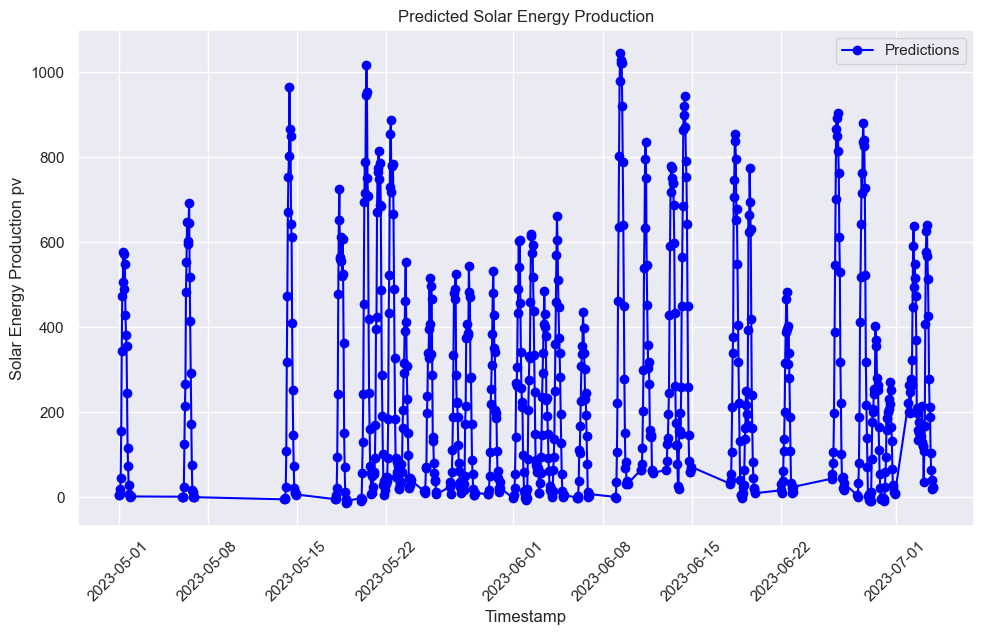

In [94]:
pred_df = X_test_b.copy()
pred_df["prediction"] = preds.as_data_frame()["predict"].values


plt.figure(figsize=(10, 6))
plt.plot(pred_df.index.values, pred_df['prediction'], '-o', label='Predictions', color='blue')
plt.title('Predicted Solar Energy Production')
plt.xlabel('Timestamp')
plt.ylabel('Solar Energy Production pv')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

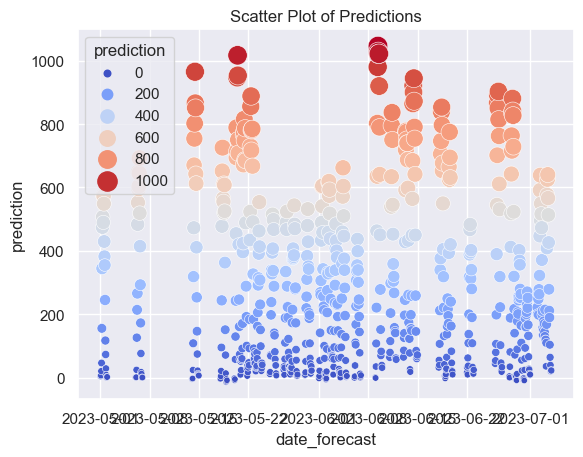

In [93]:
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("notebook")
sns.scatterplot(x='date_forecast', y='prediction', data=pred_df.reset_index(), hue='prediction', palette="coolwarm", size='prediction', sizes=(20, 200))
plt.title("Scatter Plot of Predictions");

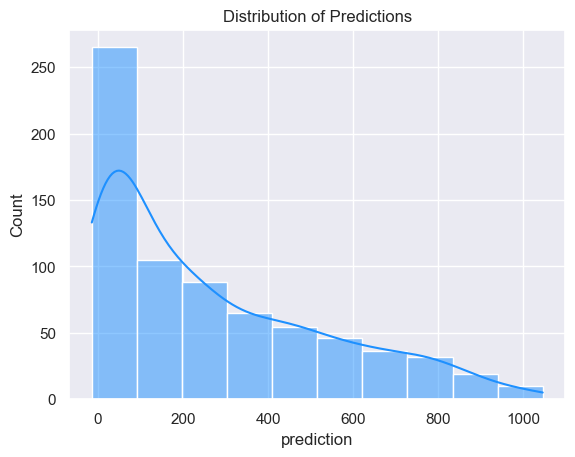

In [91]:
sns.histplot(pred_df['prediction'], bins=10, kde=True, color='dodgerblue')
plt.title("Distribution of Predictions");

In [ ]:
#Create submission
sample_submission = pd.read_csv('sample_submission.csv')
#Merge prediction from model.predict(X_test_b) into sample_submission
#sample_submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
#sample_submission.to_csv('my_first_submission.csv', index=False)
sample_submission